# Imports

In [1]:
import os
# If you are running this from ~/python_scripts/mycode.py
# change directory to the root of the repository
# All utils assume that the working directory is the root directory of the github folder
os.chdir('../')

import sys
sys.path.insert(0, os.path.join(os.getcwd(),'utils'))

# import local utils
from laplacian_renormalization import laplacian_renormalization

In [2]:
from collections import Counter
import numpy as np
import networkx as nx
from scipy.linalg import expm, sinm, cosm
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as li

In [3]:
tau = 0.1
G = nx.karate_club_graph()
mapping, wel = laplacian_renormalization(G, tau)

In [4]:
wel.head()

,source,target,weight
0,0,1,1.0
1,0,2,1.0
2,0,3,1.0
3,0,4,1.0
4,0,5,1.0


In [5]:
mapping.tail()

,micro,macro
29,29,29
30,30,30
31,31,31
32,32,32
33,33,34


In [6]:
import matplotlib as mpl
def visualize_micro_macro(G_micro, G_macro, macro_mapping, tau=1.0,
                          ns=50, lw=1.5, ec='.5', nc='w', nec='steelblue',
                          macroscale_colorful=True, macroscale_cmap='Set2',
                          macro_labeling_match=True):
    """
    Visualize microscale and macroscale networks side by side.

    Parameters:
    - G_micro (nx.Graph): Microscale network (a NetworkX graph).
    - G_macro (nx.Graph): Macroscale network (a NetworkX graph).
    - macro_mapping (pd.DataFrame): Micro-Macro mapping.
    - ns (int, optional): Node size for visualization. Default is 50.
    - lw (float, optional): Linewidth for edges. Default is 1.5.
    - ec (str, optional): Edge color. Default is '.5' (gray).
    - nc (str, optional): Node color. Default is 'w' (white).
    - nec (str, optional): Node edge color. Default is 'steelblue'.
    - macroscale_colorful (bool, optional): Whether to color macroscale nodes
                        differently if they are not in the microscale network.
                        Default is True, which assigns different colors to
                        macroscale nodes not present in the microscale network.
    - macro_labeling_match (bool, optional): Does the labeling scheme match
                        between the microscale and macroscale? I.e. do micro
                        nodes in the macro scale share the same label as their
                        corresponding node in the microscale network?

    Returns:
    - None: This function plots and displays the microscale
            and macroscale networks side by side.
    """

    # Create a figure with two subplots for microscale and macroscale networks
    fig, ax = plt.subplots(1,2,figsize=(10,4.5),dpi=200)

    # Position the nodes of the microscale network using a spring layout
    pos_micro = nx.spring_layout(G_micro)

    # Relabel nodes in order to visualize
    if type(macro_mapping) == dict:
        macro_mapping = pd.DataFrame({"micro":list(macro_mapping.keys()),
                                      "macro":list(macro_mapping.values())})

#     if type(macro_mapping) != pd.DataFrame:

    if not macro_labeling_match:
        macro_labels = np.unique(sorted(macro_mapping['macro'].values))
        G_macro = nx.relabel_nodes(G_macro,
                                   dict(zip(list(G_macro.nodes()),
                                                 macro_labels))).copy()

    # for positioning the macroscale network, our go-to will be 
    # to first assign (and fix) the positions of the micronodes
    # that were not coarse-grained to their original pos_micro value
    fixed_macro = [i for i in pos_micro.keys()
                   if i in list(G_macro.nodes())]

    # Initialize macroscale nodes based on the microscale positions or random positions
    macro_init = {i:pos_micro[i] if i in list(pos_micro.keys())
                  else np.random.rand(2) for i in G_macro.nodes()}
    if len(fixed_macro)>0:
        pos_macro = nx.spring_layout(G_macro, pos=macro_init, fixed=fixed_macro)
    else:
        pos_macro = nx.spring_layout(G_macro)

    G_cg = nx.to_undirected(G_macro)

    # plot microscale network
    nx.draw(G_micro, pos_micro, ax=ax[0],
            node_size=ns,
            linewidths=lw,
            edge_color=ec,
            node_color=nc,
            edgecolors=nec)
    
    # plot macroscale network
    ncs = ['limegreen' if i not in G_micro.nodes() else nc for i in G_cg.nodes()]
    if macroscale_colorful:
        macro_not_in_micro = [i for i in G_cg.nodes() if i not in list(G_micro.nodes())]
        n_macro = len(macro_not_in_micro)
        new_colors = mpl.cm.get_cmap(macroscale_cmap)(np.linspace(0,1,n_macro))
        ncs = [nc for i in G_cg.nodes()]
        z = 0
        for ix, nc_i in enumerate(list(G_cg.nodes())):
            if nc_i in macro_not_in_micro:
                ncs[ix] = new_colors[z]
                z+=1

    nx.draw(G_cg, pos_macro, ax=ax[1],
            node_size=[ns*4 if i not in G_micro.nodes() else ns for i in G_cg.nodes()],
            edge_color=ec,
            linewidths=lw,
            node_color=ncs,
            edgecolors=['k' if i not in G_micro.nodes()
                        else nec for i in G_cg.nodes()])

    ax[0].set_title(r'Original network')
    ax[1].set_title(r'Coarse-grained network, $\tau=%.3f$'%tau)

    plt.show()

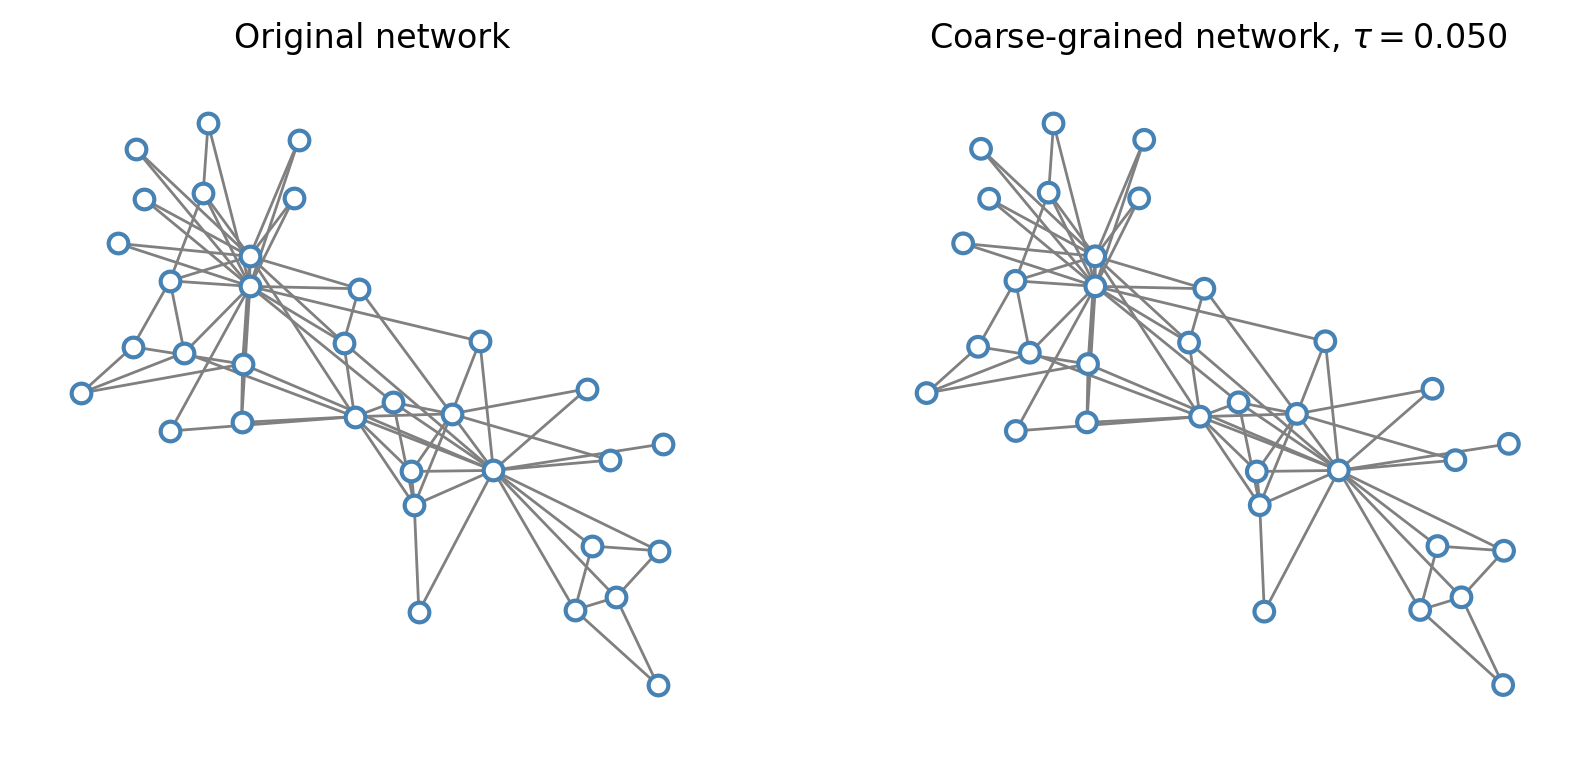

/usr/local/anaconda3/envs/covid/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


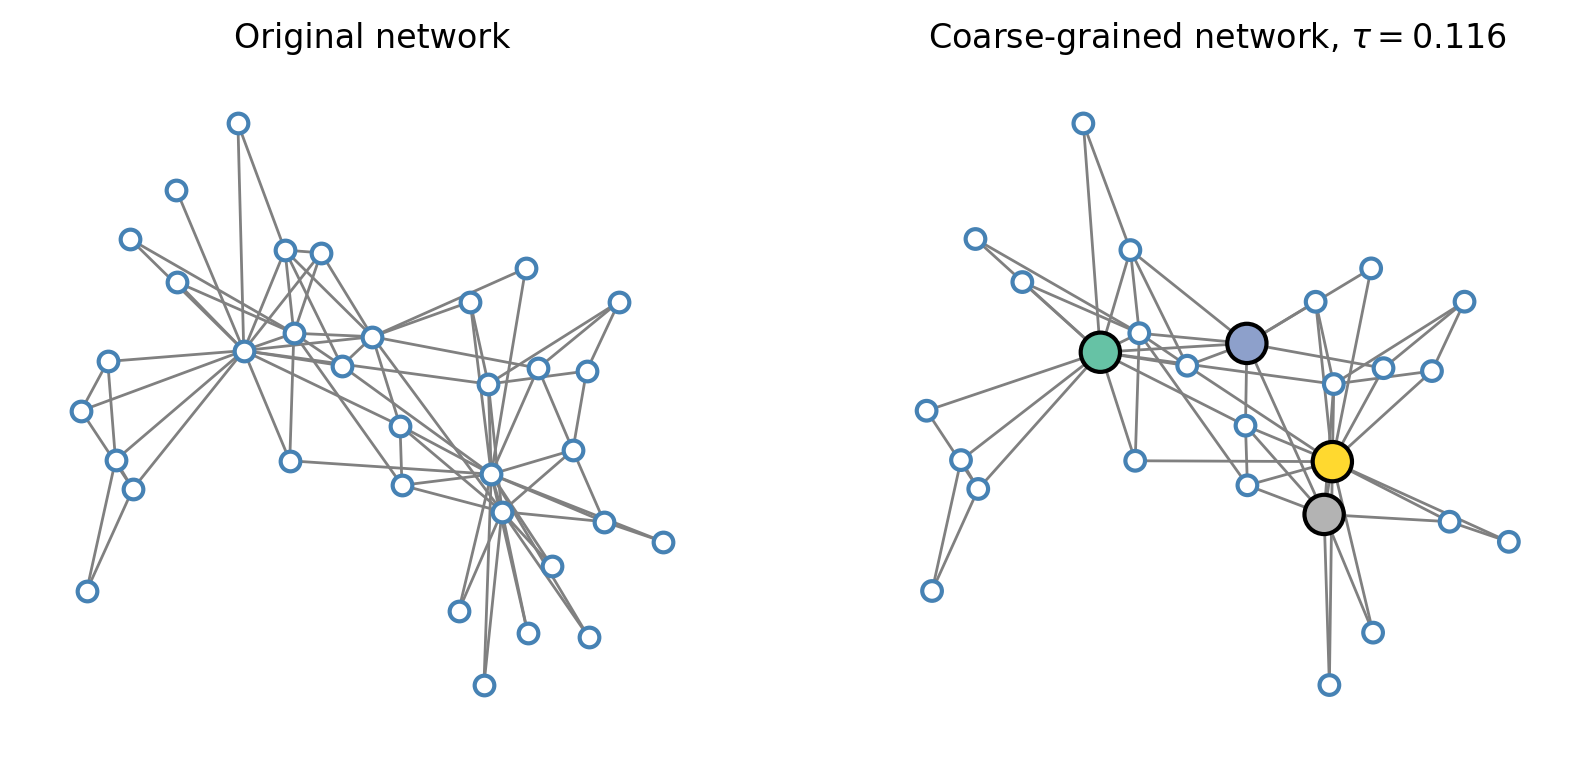

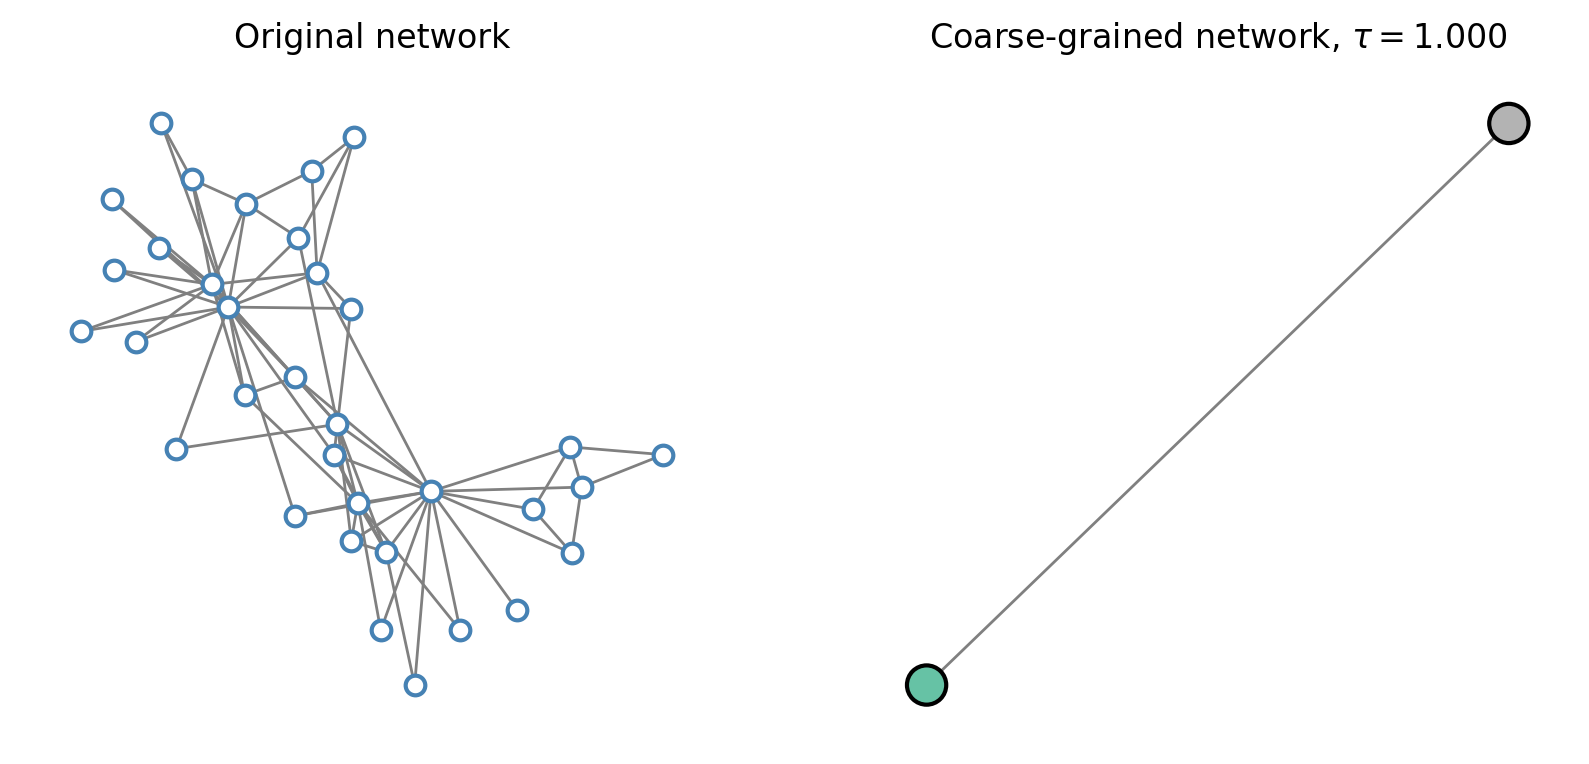

In [7]:
taus = [0.05, 0.116, 1.0]
for i,tau_i in enumerate(taus):
    G = nx.karate_club_graph()
    G_macro = laplacian_renormalization(G, tau_i, dev=True)
    visualize_micro_macro(G, G_macro, mapping, tau_i)

# Unique aspect of this method: the $\tau$ parameter

In [8]:
def preferential_attachment_network(N, alpha=1.0, m=1):
    r"""
    Generates a network based off of a preferential attachment growth rule.
    Under this growth rule, new nodes place their $m$ edges to nodes already
    present in the graph, G, with a probability proportional to $k^\alpha$.

    Parameters
    ----------
    N (int): the desired number of nodes in the final network
    alpha (float): the exponent of preferential attachment. When alpha is less
                   than 1.0, we describe it as sublinear preferential
                   attachment. At alpha > 1.0, it is superlinear preferential
                   attachment. And at alpha=1.0, the network was grown under
                   linear preferential attachment, as in the case of
                   Barabasi-Albert networks.
    m (int): the number of new links that each new node joins the network with.

    Returns
    -------
    G (nx.Graph): a graph grown under preferential attachment.

    """

    G = nx.Graph()
    G = nx.complete_graph(m+1)

    for node_i in range(m+1, N):
        degrees = np.array(list(dict(G.degree()).values()))
        probs = (degrees**alpha) / sum(degrees**alpha)
        eijs = np.random.choice(
                    G.number_of_nodes(), size=(m,),
                    replace=False, p=probs)
        for node_j in eijs:
            G.add_edge(node_i, node_j)

    return G


In [9]:
# Span a range of tau values
taus = np.logspace(-2,4,200)

N = 100
m = 2
p = 0.04
r = p*3
n_iter = 20

sizes_GG_avg = []
sizes_ER_avg = []
sizes_BA_avg = []
for xx in range(n_iter):
    print(np.round(xx/n_iter,3))
    sizes_GG = []
    sizes_ER = []
    sizes_BA = []

    # Karate Club Graph
    for tau_i in taus:
        G = nx.barabasi_albert_graph(N,m)
        density = nx.density(G)
        G_macro = laplacian_renormalization(G, tau_i, dev=True)
        sizes_BA.append(G_macro.number_of_nodes()/G.number_of_nodes())

        G = nx.random_geometric_graph(N,density*3)
        G_macro = laplacian_renormalization(G, tau_i, dev=True)
        sizes_GG.append(G_macro.number_of_nodes()/G.number_of_nodes())

        G = nx.erdos_renyi_graph(N,density)
        G_macro = laplacian_renormalization(G, tau_i, dev=True)
        sizes_ER.append(G_macro.number_of_nodes()/G.number_of_nodes())
        
    sizes_GG_avg.append(sizes_GG)
    sizes_ER_avg.append(sizes_ER)
    sizes_BA_avg.append(sizes_BA)
    
sizes_GG = np.array(sizes_GG_avg).mean(axis=0)
sizes_ER = np.array(sizes_ER_avg).mean(axis=0)
sizes_BA = np.array(sizes_BA_avg).mean(axis=0)

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


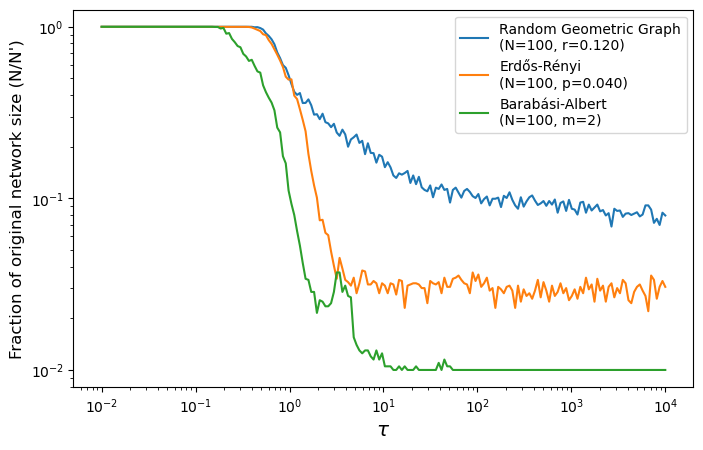

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=100)

ax.loglog(taus,sizes_GG, label='Random Geometric Graph\n(N=%i, r=%.3f)'%(N,r))
ax.loglog(taus,sizes_ER, label='Erdős-Rényi\n(N=%i, p=%.3f)'%(N,p))
ax.loglog(taus,sizes_BA, label='Barabási-Albert\n(N=%i, m=%i)'%(N,m))

ax.set_ylabel("Fraction of original network size (N/N')",fontsize='large')
ax.set_xlabel(r"$\tau$",fontsize='x-large')
ax.legend()

plt.show()

In [42]:
n_alphas = 21
n_taus = 100

alphas = np.linspace(-10,10,n_alphas)
taus = np.logspace(-2,3,n_taus)
sizes_alpha_out = {a:[] for a in alphas}

N = 100
m = 2
n_iter = 30

for a in alphas[1:]:
    print(a)
    for xx in range(n_iter):
        sizes_alpha = []

        for tau_i in taus:
            G = preferential_attachment_network(N, alpha=a, m=m)
            G_macro = laplacian_renormalization(G, tau_i, dev=True)
            sizes_alpha.append(G_macro.number_of_nodes()/G.number_of_nodes())

        sizes_alpha_out[a].append(sizes_alpha)

    sizes_alpha_out[a] = np.array(sizes_alpha_out[a]).mean(axis=0)

-9.0
-8.0
-7.0
-6.0
-5.0
-4.0
-3.0
-2.0
-1.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


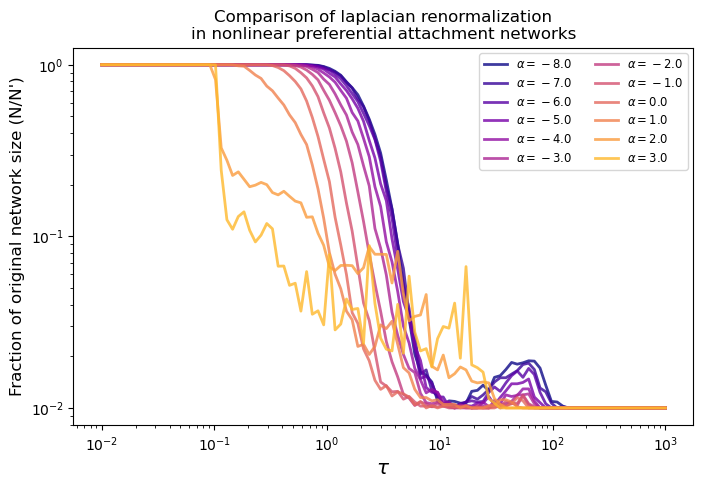

In [51]:
fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=100)

cols = plt.cm.plasma(np.linspace(0,1,len(alphas[2:-7])+2))
for ai,a in enumerate(alphas[2:-7]):
    ax.loglog(taus, sizes_alpha_out[a], color=cols[ai],
              label=r'$\alpha=%.1f$'%(a), alpha=0.8, lw=2)
    

ax.set_ylabel("Fraction of original network size (N/N')",fontsize='large')
ax.set_xlabel(r"$\tau$",fontsize='x-large')
ax.legend(fontsize='small',ncol=2)
ax.set_title('Comparison of laplacian renormalization\nin nonlinear preferential attachment networks',
             fontsize='large')

# plt.savefig('figs/pdfs/laplacian_nlpa.pdf',bbox_inches='tight')
# plt.savefig('figs/pngs/laplacian_nlpa.png',dpi=425,bbox_inches='tight')
plt.show()